## Data Set link :https://www.kaggle.com/datasets/shahidd/face-mask-ds

In [62]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
from PIL import Image
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model
import warnings
warnings.filterwarnings('ignore')

In [63]:
os.listdir('/kaggle/input/face-mask-ds')

['Dataset']

## Reading Data

In [64]:
def plot_images_from_directory(directory_path, image_name, num_images=9):
    # Retrieve list of all file names in the directory
    image_filenames = os.listdir(directory_path)

    # If there are fewer images than requested, we'll just show them all
    if len(image_filenames) < num_images:
        print(f"Only found {len(image_filenames)} images in {directory_path}, displaying them all.")
        num_images = len(image_filenames)

    # Randomly select 'num_images' number of file names
    selected_images = random.sample(image_filenames, num_images)

    # Plotting the images
    fig, axes = plt.subplots(3, 3, figsize=(8, 8))  # Adjust the size as needed
    axes = axes.ravel()

    for i, image_file in enumerate(selected_images):
        image_path = os.path.join(directory_path, image_file)
        image = Image.open(image_path)
        axes[i].imshow(image)
        axes[i].set_title(f"Image: {image_name}")
        axes[i].axis('off')  # Hide the axis

    plt.tight_layout()
    plt.show()

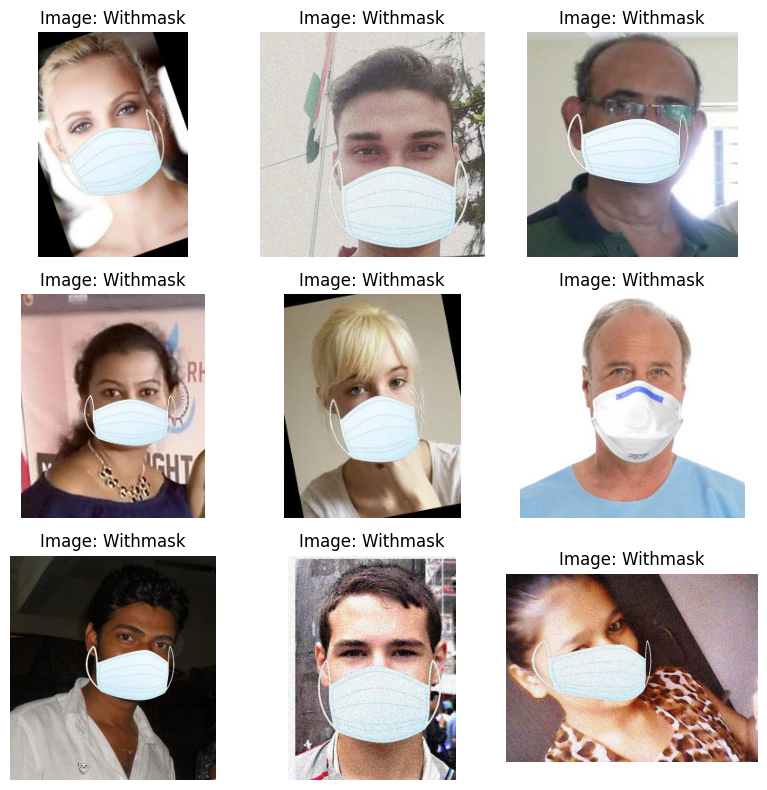

In [65]:
# Placeholder for the directory path
cat_directory_path = '/kaggle/input/face-mask-ds/Dataset/train/with_mask'  
plot_images_from_directory(cat_directory_path, image_name = 'Withmask')

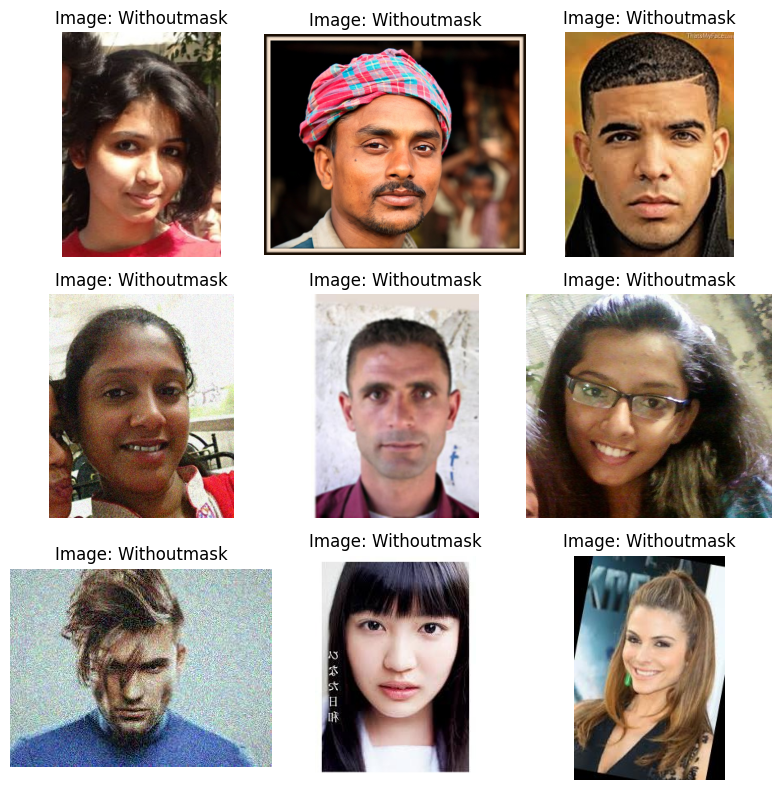

In [66]:
# Placeholder for the directory path
cat_directory_path = '/kaggle/input/face-mask-ds/Dataset/train/without_mask'  
plot_images_from_directory(cat_directory_path, image_name = 'Withoutmask')

In [67]:
def count_files_in_subdirs(directory, set_name):
    # Initialize an empty dictionary to hold the count of files for each subdirectory.
    counts = {}

    # Iterate over each item in the given directory.
    for item in os.listdir(directory):
        # Construct the full path to the item.
        item_path = os.path.join(directory, item)

        # Check if the item is a directory.
        if os.path.isdir(item_path):
            # Count the number of files in the subdirectory and add it to the dictionary.
            counts[item] = len(os.listdir(item_path))

    # Convert the counts dictionary to a DataFrame for easy viewing and analysis.
    # The index of the DataFrame is set to the provided set name.
    df = pd.DataFrame(counts, index=[set_name])
    return df

# Paths to the training and testing directories.
train_dir='/kaggle/input/face-mask-ds/Dataset/train'
test_dir = '/kaggle/input/face-mask-ds/Dataset/test'

# Count the files in the subdirectories of the training directory and print the result.
train_count = count_files_in_subdirs(train_dir, 'train')
print(train_count)

# Count the files in the subdirectories of the testing directory and print the result.
test_count = count_files_in_subdirs(test_dir, 'test')
print(test_count)


       without_mask  with_mask
train           652        653
      without_mask  with_mask
test            97         97


In [68]:
image = '/kaggle/input/face-mask-ds/Dataset/train/without_mask/withoutmask (1).jpeg'

import cv2

img = cv2.imread(image) # Default load in color format.

# If the image is loaded successfully, print its pixel values
if img is not None:
    # print(img)
    print("Shape:", img.shape)
else:
    print("The image could not be loaded. Please check the path and file permissions.")

Shape: (840, 640, 3)


#                                       ****Model Building****

# Model -1 CNN

In [69]:
# Define paths to the train and validation directories
train_data_dir = '/kaggle/input/face-mask-ds/Dataset/train'
test_data_dir = '/kaggle/input/face-mask-ds/Dataset/test'

In [70]:
# Set some parameters
img_width, img_height = 150, 150
batch_size = 10
epochs = 7
num_classes = 2 

In [71]:
# Rescale the pixel values (0-255) to the [0, 1] interval
data_generator = ImageDataGenerator(rescale=1./255,validation_split=0.2)

# Automatically retrieve images and their classes for train and validation sets
train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='training')

validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation')

test_generator = data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),  
    batch_size=10,  
    class_mode='binary',  
    shuffle=True) 
    
 

Found 1045 images belonging to 2 classes.
Found 260 images belonging to 2 classes.
Found 194 images belonging to 2 classes.


In [72]:
# Accessing class labels for the training data
train_class_labels = train_generator.class_indices
print("Training class labels:", train_class_labels)

# Accessing class labels for the validation data
validation_class_labels = validation_generator.class_indices
print("Validation class labels:", validation_class_labels)

# Accessing class labels for the validation data
test_class_labels = test_generator.class_indices
print("Validation class labels:", test_class_labels)

Training class labels: {'with_mask': 0, 'without_mask': 1}
Validation class labels: {'with_mask': 0, 'without_mask': 1}
Validation class labels: {'with_mask': 0, 'without_mask': 1}


In [73]:
# Initialising the CNN

model = models.Sequential([
    layers.Conv2D(100, (3,3), activation='relu',input_shape=(img_width, img_height, 3)),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(100, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Flatten(),
    layers.Dense(50, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 100)  │         2,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 100)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 100)    │        90,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 100)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 129600)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │     6,480,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,573,001 (25.07 MB)

 Trainable params: 6,573,001 (25.07 MB)

 Non-trainable params: 0 (0.00 B)

In [74]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [75]:
train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1
print(train_steps_per_epoch)
print(validation_steps_epoch)
print(test_steps_epoch)

105
27
20


In [76]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=validation_steps_epoch,
    )

Epoch 1/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 15s 91ms/step - accuracy: 0.6901 - loss: 0.9185 - val_accuracy: 0.9538 - val_loss: 0.1858
Epoch 2/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9538 - val_loss: 0.1858
Epoch 3/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.9213 - loss: 0.2001 - val_accuracy: 0.9577 - val_loss: 0.1729
Epoch 4/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9577 - val_loss: 0.1729
Epoch 5/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9773 - loss: 0.0824 - val_accuracy: 0.9423 - val_loss: 0.1938


In [77]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.9732 - loss: 0.0862
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.9086 - loss: 0.2311
final train accuracy = 97.22 , validation accuracy = 92.78


In [78]:
probabilities = model.predict(test_generator)
probabilities

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


array([[9.4909161e-01],
       [1.7458028e-03],
       [3.7176500e-04],
       [1.8312219e-05],
       [9.7153902e-01],
       [5.7198590e-01],
       [2.5273061e-01],
       [9.7400290e-01],
       [7.1369263e-04],
       [9.9528730e-01],
       [1.2776308e-04],
       [2.9667625e-02],
       [7.7520999e-06],
       [5.9910256e-01],
       [1.1764829e-02],
       [9.8907530e-01],
       [8.3832270e-01],
       [9.5935655e-01],
       [2.7764179e-03],
       [1.8047124e-04],
       [5.6387490e-01],
       [4.3917639e-04],
       [8.0967575e-01],
       [2.5630635e-04],
       [6.5642489e-05],
       [1.6133326e-01],
       [7.3887998e-01],
       [1.8570130e-01],
       [2.0158480e-01],
       [1.7872431e-03],
       [1.3300711e-01],
       [2.7083731e-04],
       [9.4743508e-01],
       [9.7795039e-01],
       [9.9489903e-01],
       [1.6356055e-02],
       [9.8848569e-01],
       [4.5172572e-01],
       [2.6651978e-04],
       [9.8911369e-01],
       [9.8953396e-01],
       [4.014207

In [79]:
test_generator.reset()

# Get the true labels
true_classes = test_generator.classes
Steps=int(np.ceil(test_generator.samples/test_generator.batch_size))
probabilities = model.predict(test_generator,steps=Steps)
predicted_classes = np.argmax(probabilities,axis=1)



# The output is the probability of the positive class,
# so we will threshold it at 0.5 to decide the predicted class
predicted_classes = (probabilities > 0.5).astype(int).squeeze()


# Class labels are just [0, 1] for binary classification, or you can use custom labels if you have them
class_labels = list(test_generator.class_indices.keys())
predicted_classes

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


array([1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1])

<function matplotlib.pyplot.show(close=None, block=None)>

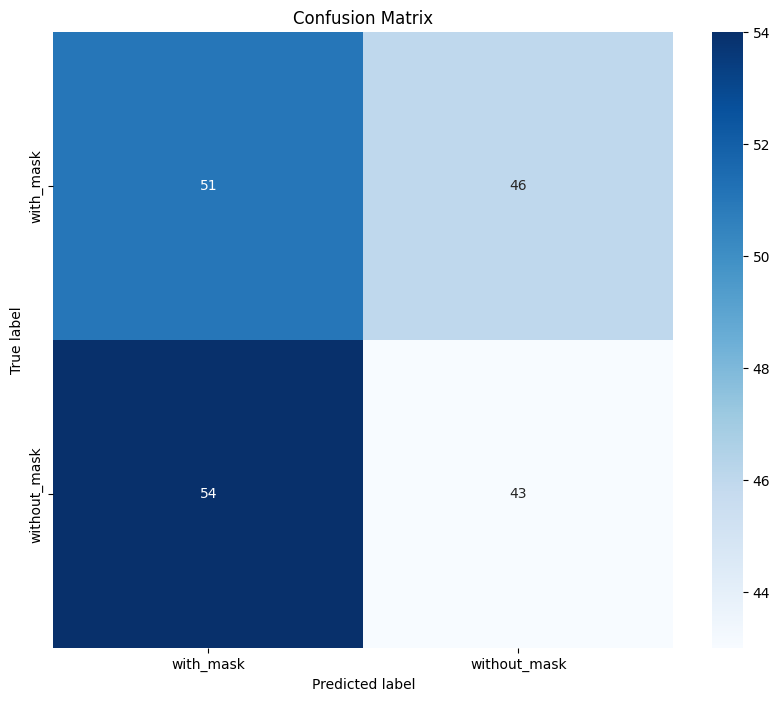

In [80]:
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show

In [81]:
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

   with_mask       0.49      0.53      0.50        97
without_mask       0.48      0.44      0.46        97

    accuracy                           0.48       194
   macro avg       0.48      0.48      0.48       194
weighted avg       0.48      0.48      0.48       194



In [82]:
def make_prediction(image_path):
    img = load_img(img_path, target_size=(150, 150))  # Resizing the image
    img_array = img_to_array(img)  # Converting to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.  # Rescale the image similarly as we did for the training data

    prediction = model.predict(img_array)
    print("Prediction:", prediction)

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')

    # Prediction
    plt.subplot(1, 2, 2)
    if prediction[0][0] > 0.5:
        plt.title('Predicted: Withoutmask')
    else:
        plt.title('Predicted: withmask')
    plt.imshow(img)  # Show the same image as prediction
    plt.axis('off')

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 807ms/step
Prediction: [[0.00065256]]


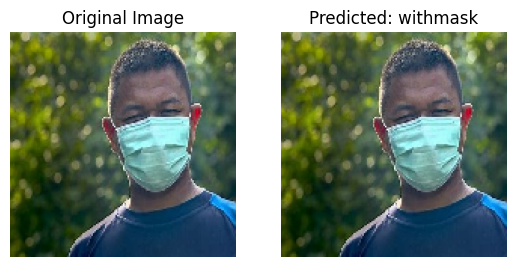

In [83]:
# Load and preprocess the image
img_path = '/kaggle/input/samples/samples/lll.jpg'

make_prediction(img_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Prediction: [[0.84294343]]


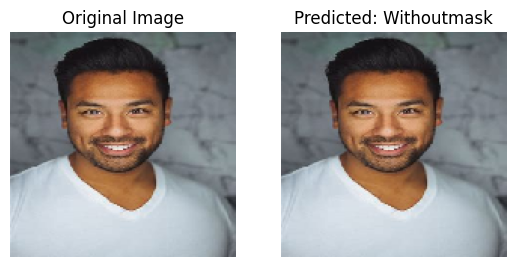

In [84]:
# Load and preprocess the image
img_path = '/kaggle/input/samples/samples/mmm.jpg'

make_prediction(img_path)

In [85]:
from tensorflow import keras
model.save("CNN_model.keras")

# Model -2 Using  DataAuguementation

In [86]:
# Define paths to the train and validation directories
train_data_dir = '/kaggle/input/face-mask-ds/Dataset/train'
test_data_dir = '/kaggle/input/face-mask-ds/Dataset/test'

In [87]:
# Set some parameters
img_width, img_height = 150, 150
batch_size = 10
epochs = 7
num_classes = 2 

In [88]:
# Initializing the ImageDataGenerator with data augmentation options for the training set
data_generator = ImageDataGenerator(
    rescale=1./255,  
    rotation_range=40,  
    width_shift_range=0.2,  
    height_shift_range=0.2, 
    shear_range=0.2,
    zoom_range=0.2,  
    horizontal_flip=True,  
    fill_mode='nearest',  
    validation_split=0.1
)
# Rescale the pixel values (0-255) to the [0, 1] interval
test_data_generator = ImageDataGenerator(rescale=1./255)

# Automatically retrieve images and their classes for train and validation sets
train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    #color_mode='grayscale',
    shuffle=True,
    subset='training')

validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    #color_mode='grayscale',
    subset='validation')

test_generator = test_data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),  # Should match the input size of your network
    batch_size=10,  # Can adjust based on your memory constraints
    class_mode='binary',  # Since we use binary_crossentropy loss, we need binary labels
    shuffle=True) 
    
 

Found 1175 images belonging to 2 classes.
Found 130 images belonging to 2 classes.
Found 194 images belonging to 2 classes.


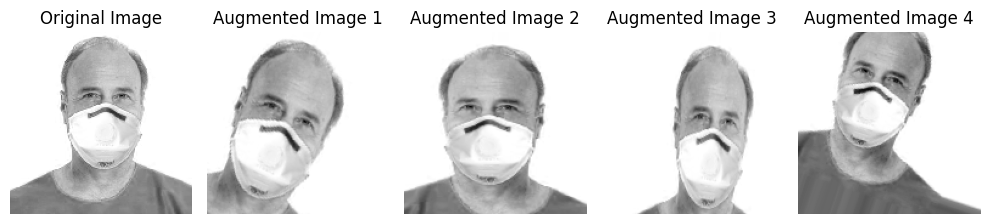

In [89]:
# Path to your specific image
image_path = '/kaggle/input/face-mask-ds/Dataset/train/with_mask/withmask (1).jpeg'

# Load and convert the image to an array
img = load_img(image_path, color_mode='rgb', target_size=(img_width, img_height))  # Adjust color_mode if necessary
img_array = img_to_array(img)  # Converts the image to a numpy array
img_array = img_array.reshape((1,) + img_array.shape)  # Reshapes the image to (1, width, height, channels) for the generator

# Setting up the plot
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 4))
# Plot the original image first. Since img_array is a 3D array after reshaping, we use [:, :, 0]
axes[0].imshow(img_array[0, :, :, 0], cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# Generate and plot augmented images
for i, ax in enumerate(axes.flat[1:]):  # Start from the second subplot
    # Generate a batch of augmented images
    aug_iter = data_generator.flow(img_array, batch_size=1)
    aug_img = next(aug_iter)[0]  # Get the first augmented image from the batch

    # Plot the augmented image. We directly use [:, :, 0] without an initial batch index
    ax.imshow(aug_img[:, :, 0], cmap='gray')
    ax.set_title(f'Augmented Image {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [90]:
# Accessing class labels for the training data
train_class_labels = train_generator.class_indices
print("Training class labels:", train_class_labels)

# Accessing class labels for the validation data
validation_class_labels = validation_generator.class_indices
print("Validation class labels:", validation_class_labels)

# Accessing class labels for the validation data
test_class_labels = test_generator.class_indices
print("Validation class labels:", test_class_labels)

Training class labels: {'with_mask': 0, 'without_mask': 1}
Validation class labels: {'with_mask': 0, 'without_mask': 1}
Validation class labels: {'with_mask': 0, 'without_mask': 1}


In [91]:
# Initialising the CNN

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu',input_shape=(img_width, img_height, 3),padding='same'),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.2),

    layers.Conv2D(64, (5,5), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.2),
    

    
    layers.Flatten(),
    layers.Dense(80, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 71, 71, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 35, 35, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 35, 35, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 78400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 80)             │     6,272,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            81 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,324,321 (24.13 MB)

 Trainable params: 6,324,321 (24.13 MB)

 Non-trainable params: 0 (0.00 B)

In [92]:
# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)
callbacks = [ earlystop, reduce_lr]

In [93]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy']
              )

In [94]:
train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1
print(train_steps_per_epoch)
print(validation_steps_epoch)
print(test_steps_epoch)

118
14
20


In [95]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_steps_epoch,
    callbacks=callbacks
    )

Epoch 1/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - accuracy: 0.5227 - loss: 0.7494 - val_accuracy: 0.8154 - val_loss: 0.5843 - learning_rate: 1.0000e-04
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8385 - val_loss: 0.6037 - learning_rate: 1.0000e-04
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - accuracy: 0.8026 - loss: 0.4576 - val_accuracy: 0.8615 - val_loss: 0.4083 - learning_rate: 1.0000e-04
Epoch 4/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8538 - val_loss: 0.4323 - learning_rate: 1.0000e-04
Epoch 5/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - accuracy: 0.8480 - loss: 0.3531 - val_accuracy: 0.7615 - val_loss: 0.5054 - learning_rate: 1.0000e-04
Epoch 6/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8077 - val_loss: 0.4480 - learning_rate: 1.0000e-04
Epoch 6: early stopping
Restorin

In [96]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - accuracy: 0.8523 - loss: 0.4151
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.9115 - loss: 0.3406
final train accuracy = 85.45 , validation accuracy = 91.75


In [97]:
probabilities = model.predict(test_generator)
probabilities

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


array([[0.54847085],
       [0.11909784],
       [0.2615654 ],
       [0.57293224],
       [0.17140207],
       [0.89323944],
       [0.6112813 ],
       [0.31684065],
       [0.83795094],
       [0.2048993 ],
       [0.22806662],
       [0.36514866],
       [0.24065027],
       [0.42546505],
       [0.7965662 ],
       [0.7737599 ],
       [0.5201247 ],
       [0.9183564 ],
       [0.23163626],
       [0.39016855],
       [0.20620473],
       [0.345776  ],
       [0.8073908 ],
       [0.19786927],
       [0.68949085],
       [0.31519312],
       [0.5373768 ],
       [0.90029997],
       [0.8678906 ],
       [0.8485683 ],
       [0.22799027],
       [0.8696636 ],
       [0.57208824],
       [0.43772686],
       [0.27348045],
       [0.61491746],
       [0.8444295 ],
       [0.5536998 ],
       [0.51093674],
       [0.7978589 ],
       [0.8835452 ],
       [0.8357452 ],
       [0.87997115],
       [0.28378472],
       [0.8712687 ],
       [0.23687021],
       [0.85263044],
       [0.253

In [98]:
test_generator.reset()

# Get the true labels
true_classes = test_generator.classes
Steps=int(np.ceil(test_generator.samples/test_generator.batch_size))
predictions = model.predict(test_generator,steps=Steps)
predicted_classes = np.argmax(predictions,axis=1)

# The output is the probability of the positive class,
# so we will threshold it at 0.5 to decide the predicted class
predicted_classes = (probabilities > 0.5).astype(int).squeeze()


# Class labels are just [0, 1] for binary classification, or you can use custom labels if you have them
class_labels = list(test_generator.class_indices.keys())
predicted_classes

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


array([1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1])

<function matplotlib.pyplot.show(close=None, block=None)>

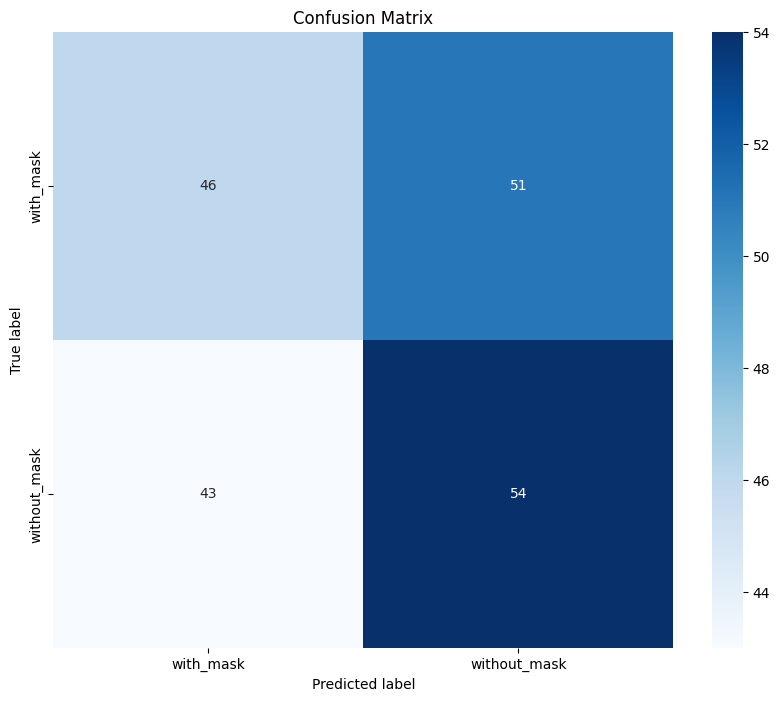

In [99]:
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show

In [100]:
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

   with_mask       0.52      0.47      0.49        97
without_mask       0.51      0.56      0.53        97

    accuracy                           0.52       194
   macro avg       0.52      0.52      0.51       194
weighted avg       0.52      0.52      0.51       194



In [101]:
def make_prediction(image_path):
    img = load_img(img_path, target_size=(150, 150))  # Resizing the image
    img_array = img_to_array(img)  # Converting to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.  # Rescale the image similarly as we did for the training data

    prediction = model.predict(img_array)
    print("Prediction:", prediction)

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')

    # Prediction
    plt.subplot(1, 2, 2)
    if prediction[0][0] > 0.5:
        plt.title('Predicted: Withoutmask')
    else:
        plt.title('Predicted: withmask')
    plt.imshow(img)  # Show the same image as prediction
    plt.axis('off')

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step
Prediction: [[0.27196622]]


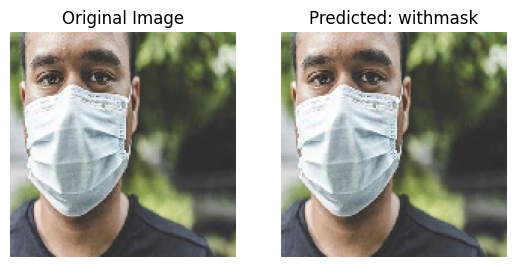

In [102]:
# Load and preprocess the image
img_path = '/kaggle/input/samples/samples/OIP.jpg'

make_prediction(img_path)

In [103]:
model.save("Imageauguementation_model.keras")

# Model-3  Transfer Learning VGGNET

In [104]:
# Define paths to the train and validation directories
train_data_dir = '/kaggle/input/face-mask-ds/Dataset/train'
test_data_dir = '/kaggle/input/face-mask-ds/Dataset/test'

In [105]:
# Set some parameters
img_width, img_height = 150, 150
batch_size = 10
epochs = 7
num_classes = 2 

In [106]:
# Initializing the ImageDataGenerator with data augmentation options for the training set
data_generator = ImageDataGenerator(
    rescale=1./255,  
    rotation_range=40,  
    width_shift_range=0.2,  
    height_shift_range=0.2, 
    shear_range=0.2,
    zoom_range=0.2,  
    horizontal_flip=True,  
    fill_mode='nearest'
)
# Rescale the pixel values (0-255) to the [0, 1] interval
test_data_generator = ImageDataGenerator(rescale=1./255)

# Automatically retrieve images and their classes for train and validation sets
train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    #color_mode='grayscale',
    subset='training')

test_generator = test_data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),  # Should match the input size of your network
    batch_size=10,  # Can adjust based on your memory constraints
    class_mode='binary',  # Since we use binary_crossentropy loss, we need binary labels
    shuffle=True) 
    
 

Found 1305 images belonging to 2 classes.
Found 194 images belonging to 2 classes.


In [107]:
# Extract class labels for all instances in the training dataset
classes = np.array(train_generator.classes)

# Calculate class weights to handle imbalances in the training data
# 'balanced' mode automatically adjusts weights inversely proportional to class frequencies
class_weights = compute_class_weight(
    class_weight='balanced',  # Strategy to balance classes
    classes=np.unique(classes),  # Unique class labels
    y=classes  # Class labels for each instance in the training dataset
)

# Create a dictionary mapping class indices to their calculated weights
class_weights_dict = dict(enumerate(class_weights))

# Output the class weights dictionary
print("Class Weights Dictionary:", class_weights_dict)

Class Weights Dictionary: {0: 0.9992343032159265, 1: 1.0007668711656441}


In [108]:
test_generator.class_indices

{'with_mask': 0, 'without_mask': 1}

In [109]:
# Clear the previous TensorFlow sessionx
tf.keras.backend.clear_session()

# Load the VGG16 base model, excluding its top (fully connected) layers
vgg = VGG16(input_shape=(img_width, img_height, 3), include_top=False, weights='imagenet')
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [110]:
# Make the specified layers non-trainable
for layer in vgg.layers[:-3]:
    layer.trainable = False

vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 4,719,616 (18.00 MB)

 Non-trainable params: 9,995,072 (38.13 MB)

In [111]:
# Flattening the layer and adding custom Dense layers
classes =1
x = Flatten()(vgg.output)

# Adding a fully connected layer with ReLU activation and He normal initializer
x = Dense(100, activation='relu', kernel_initializer='he_normal')(x)
output = Dense(classes, activation='sigmoid', kernel_initializer='he_normal')(x)

# Creating the model
model = Model(inputs=vgg.input, outputs=output)

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False),
              metrics=['accuracy'])

# Model summary to see all layers
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       819,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,534,089 (59.26 MB)

 Trainable params: 5,539,017 (21.13 MB)

 Non-trainable params: 9,995,072 (38.13 MB)

In [112]:
train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
#validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1
print(train_steps_per_epoch)
#print(validation_steps_epoch)
print(test_steps_epoch)

131
20


In [113]:
history = model.fit(train_generator,
                    steps_per_epoch=train_steps_per_epoch,
                    validation_data=test_generator,
                    validation_steps=test_steps_epoch,
                    epochs=50,
                    callbacks=callbacks)
                    

Epoch 1/50
  3/131 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.4667 - loss: 0.8030

W0000 00:00:1716726328.625692     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 22/131 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 0.6148 - loss: 0.6611

W0000 00:00:1716726331.236767     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


130/131 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.8425 - loss: 0.3122

W0000 00:00:1716726341.613375     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


131/131 ━━━━━━━━━━━━━━━━━━━━ 17s 108ms/step - accuracy: 0.8438 - loss: 0.3098 - val_accuracy: 0.9897 - val_loss: 0.0203 - learning_rate: 1.0000e-04
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/50


W0000 00:00:1716726342.556695     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


131/131 ━━━━━━━━━━━━━━━━━━━━ 13s 92ms/step - accuracy: 0.9726 - loss: 0.0752 - val_accuracy: 0.9897 - val_loss: 0.0210 - learning_rate: 1.0000e-04
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 93us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 13s 91ms/step - accuracy: 0.9878 - loss: 0.0252 - val_accuracy: 0.9897 - val_loss: 0.0168 - learning_rate: 1.0000e-04
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.


In [114]:
train_loss, train_accu = model.evaluate(train_generator)

test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

131/131 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - accuracy: 0.9617 - loss: 0.0746
 1/20 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.9000 - loss: 0.1470

W0000 00:00:1716726380.176800     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9816 - loss: 0.0296
final train accuracy = 96.78 , validation accuracy = 98.97


In [115]:
probabilities = model.predict(test_generator)
probabilities

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step


array([[9.98979867e-01],
       [9.99997497e-01],
       [9.99997973e-01],
       [1.00000000e+00],
       [9.99999881e-01],
       [6.74440287e-07],
       [9.99999285e-01],
       [6.84594852e-07],
       [9.99999404e-01],
       [8.76405060e-01],
       [4.45518456e-03],
       [9.99978542e-01],
       [9.99970436e-01],
       [9.99998808e-01],
       [2.32510365e-06],
       [1.00000000e+00],
       [6.12720669e-07],
       [4.30881784e-07],
       [1.61196419e-06],
       [9.99993086e-01],
       [4.42080704e-07],
       [1.45820195e-07],
       [2.11486949e-05],
       [5.36868638e-09],
       [6.21710084e-02],
       [1.81383541e-06],
       [1.10427015e-06],
       [3.56363671e-06],
       [9.99999523e-01],
       [4.60158881e-05],
       [9.98041987e-01],
       [9.99991894e-01],
       [6.85973816e-07],
       [7.11595703e-06],
       [1.78645991e-04],
       [9.99999166e-01],
       [9.99994159e-01],
       [9.99921918e-01],
       [9.99999881e-01],
       [9.99780416e-01],


In [116]:
test_generator.reset()

# Get the true labels
true_classes = test_generator.classes
Steps=int(np.ceil(test_generator.samples/test_generator.batch_size))
predictions = model.predict(test_generator,steps=Steps)
predicted_classes = np.argmax(predictions,axis=1)

# The output is the probability of the positive class,
# so we will threshold it at 0.5 to decide the predicted class
predicted_classes = (probabilities > 0.5).astype(int).squeeze()


# Class labels are just [0, 1] for binary classification, or you can use custom labels if you have them
class_labels = list(test_generator.class_indices.keys())
predicted_classes

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


array([1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0])

<function matplotlib.pyplot.show(close=None, block=None)>

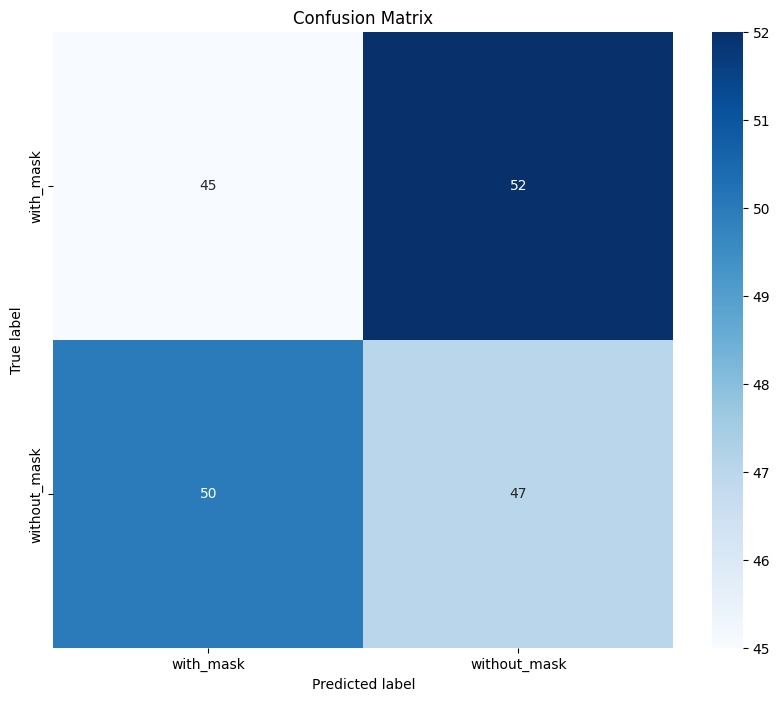

In [117]:
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show

In [118]:
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

   with_mask       0.47      0.46      0.47        97
without_mask       0.47      0.48      0.48        97

    accuracy                           0.47       194
   macro avg       0.47      0.47      0.47       194
weighted avg       0.47      0.47      0.47       194



In [119]:
def make_prediction(image_path):
    img = load_img(img_path, target_size=(150, 150))  # Resizing the image
    img_array = img_to_array(img)  # Converting to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.  # Rescale the image similarly as we did for the training data

    prediction = model.predict(img_array)
    print("Prediction:", prediction)

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')

    # Prediction
    plt.subplot(1, 2, 2)
    if prediction[0][0] > 0.5:
        plt.title('Predicted: Withoutmask')
    else:
        plt.title('Predicted: withmask')
    plt.imshow(img)  # Show the same image as prediction
    plt.axis('off')

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step
Prediction: [[0.06383377]]


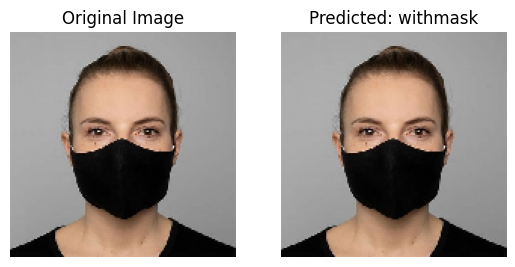

In [120]:
# Load and preprocess the image
img_path = '/kaggle/input/samples/samples/t1.jpg'

make_prediction(img_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Prediction: [[0.99999213]]


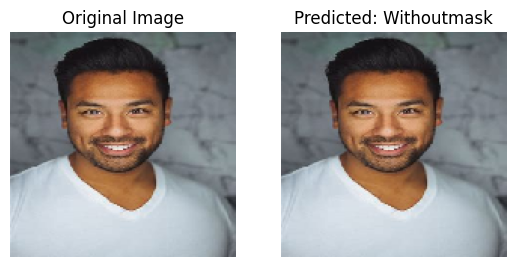

In [121]:
# Load and preprocess the image
img_path = '/kaggle/input/samples/samples/mmm.jpg'

make_prediction(img_path)

In [122]:
# Reset the test_generator before making predictions
test_generator.reset()

# Predict the whole test set
predictions = model.predict(test_generator, verbose=1)

# The predictions will be in the format of probabilities. You'll need to convert these to binary labels (0 or 1) based on a 0.5 threshold.
predicted_classes = (predictions > 0.5).astype(int).reshape(-1)
true_classes = test_generator.classes
misclassified_indices = np.where(predicted_classes != true_classes)[0]
misclassified_count = len(misclassified_indices)
print(f"Total misclassifications in the test set: {misclassified_count} out of {len(true_classes)}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Total misclassifications in the test set: 96 out of 194


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Total misclassifications: 98


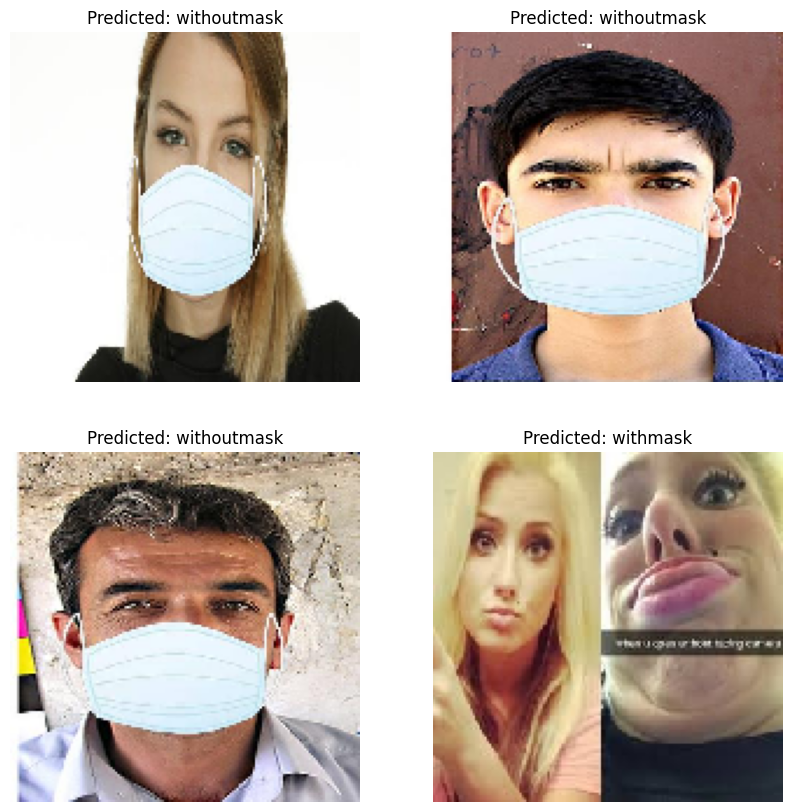

In [123]:
# Generate predictions for all test images
predictions = model.predict(test_generator)
# Convert predictions to binary (0 or 1) based on a 0.5 threshold
predicted_classes = predictions > 0.5

# Retrieve the true labels from the generator
true_classes = test_generator.classes

# Filenames can also be useful for debugging
filenames = test_generator.filenames
# Identifying indices of misclassified images
misclassified_indices = np.where(predicted_classes.flatten() != true_classes)[0]

print(f"Total misclassifications: {len(misclassified_indices)}")


# Select a random subset of misclassified images
num_samples_to_display = 4
random_indices = random.sample(list(misclassified_indices), num_samples_to_display)

# Plot
plt.figure(figsize=(10, 10))
for i, index in enumerate(random_indices, 1):
    # Load image
    img_path = test_data_dir + '/' + filenames[index]
    img = load_img(img_path, target_size=(150, 150))

    # Predicted class
    predicted_class = "withoutmask" if predicted_classes[index] else "withmask"

    # Display
    plt.subplot(2, 2, i)
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
plt.show()

In [124]:
model.save('Vgg16_model.keras')

#  Model-4 Transfer Leanring - ResNet50

In [125]:
# Define paths to the train and validation directories
train_data_dir = '/kaggle/input/face-mask-ds/Dataset/train'
test_data_dir = '/kaggle/input/face-mask-ds/Dataset/test'

In [126]:
# Set some parameters
img_width, img_height = 150, 150
batch_size = 10
epochs = 7
num_classes = 2 

In [127]:
# Initializing the ImageDataGenerator with data augmentation options for the training set
data_generator = ImageDataGenerator(
    rescale=1./255,  
    rotation_range=40,  
    width_shift_range=0.2,  
    height_shift_range=0.2, 
    shear_range=0.2,
    zoom_range=0.2,  
    horizontal_flip=True,  
    fill_mode='nearest'
)
# Rescale the pixel values (0-255) to the [0, 1] interval
test_data_generator = ImageDataGenerator(rescale=1./255)

# Automatically retrieve images and their classes for train and validation sets
train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    #color_mode='grayscale',
    shuffle=True,
    subset='training')

test_generator = test_data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),  # Should match the input size of your network
    batch_size=10,  # Can adjust based on your memory constraints
    class_mode='binary',  # Since we use binary_crossentropy loss, we need binary labels
    shuffle=True) 
    
 

Found 1305 images belonging to 2 classes.
Found 194 images belonging to 2 classes.


In [128]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model

# Define the input layer
input_tensor = Input(shape=(150, 150, 3))

base_model = ResNet50V2(weights='imagenet', include_top=False, input_tensor=input_tensor)


for layer in base_model.layers[:-50]:
    layer.trainable = False



94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [129]:

# Add new layers on top of the base model
x = base_model.output
x = Flatten()(x)  # Flatten the output to feed into the fully connected layers
x = Dense(80, activation='relu')(x)  # Add a fully connected layer
x = Dense(1, activation='sigmoid')(x)  # Add the output layer for binary classification

# Define the complete model
model = Model(inputs=input_tensor, outputs=x)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 156, 156,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 75, 75,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 77, 77,    │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 38, 38,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 38, 38,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 38, 38,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 38, 38,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 38, 38,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 38, 38,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 40, 40,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 38, 38,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 38, 38,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 38, 38,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 38, 38,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 38, 38,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 38, 38,    │          0 │ conv2_block1_0_c

 Total params: 27,660,961 (105.52 MB)

 Trainable params: 20,448,417 (78.00 MB)

 Non-trainable params: 7,212,544 (27.51 MB)

In [130]:
train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
#validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1
print(train_steps_per_epoch)
#print(validation_steps_epoch)
print(test_steps_epoch)

131
20


In [131]:
history = model.fit(train_generator,
                    steps_per_epoch=train_steps_per_epoch,
                    validation_data=test_generator,
                    validation_steps=test_steps_epoch,
                    epochs=50,
                    callbacks=callbacks)
                    

Epoch 1/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 265ms/step - accuracy: 0.8878 - loss: 0.2754 - val_accuracy: 0.9948 - val_loss: 0.0306 - learning_rate: 1.0000e-04
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 13s 93ms/step - accuracy: 0.9726 - loss: 0.0829 - val_accuracy: 0.9948 - val_loss: 0.0061 - learning_rate: 1.0000e-04
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.


In [132]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

131/131 ━━━━━━━━━━━━━━━━━━━━ 14s 106ms/step - accuracy: 0.9916 - loss: 0.0308
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9978 - loss: 0.0152
final train accuracy = 99.16 , validation accuracy = 99.48


In [133]:
probabilities = model.predict(test_generator)
probabilities

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 210ms/step


array([[8.40121158e-15],
       [1.00000000e+00],
       [1.00000000e+00],
       [6.77828965e-19],
       [1.00000000e+00],
       [9.99988198e-01],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [5.18282837e-16],
       [7.56663212e-08],
       [3.55132963e-16],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [7.86152942e-30],
       [1.73146116e-11],
       [1.00000000e+00],
       [2.95388513e-17],
       [1.00000000e+00],
       [1.00000000e+00],
       [2.90727013e-16],
       [1.00000000e+00],
       [4.09426152e-33],
       [9.14348513e-02],
       [4.93394934e-19],
       [9.99976754e-01],
       [1.00000000e+00],
       [3.37947587e-10],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [9.99998093e-01],
       [1.00000000e+00],
       [9.49940435e-21],
       [1.00000000e+00],
       [1.00000000e+00],


In [134]:
test_generator.reset()

# Get the true labels
true_classes = test_generator.classes
Steps=int(np.ceil(test_generator.samples/test_generator.batch_size))
predictions = model.predict(test_generator,steps=Steps)
predicted_classes = np.argmax(predictions,axis=1)
# Predict probabilities for the positive class
#probabilities = model.predict(test_generator
                             #)

# The output is the probability of the positive class,
# so we will threshold it at 0.5 to decide the predicted class
predicted_classes = (probabilities > 0.5).astype(int).squeeze()


# Class labels are just [0, 1] for binary classification, or you can use custom labels if you have them
class_labels = list(test_generator.class_indices.keys())
predicted_classes

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


array([0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0])

<function matplotlib.pyplot.show(close=None, block=None)>

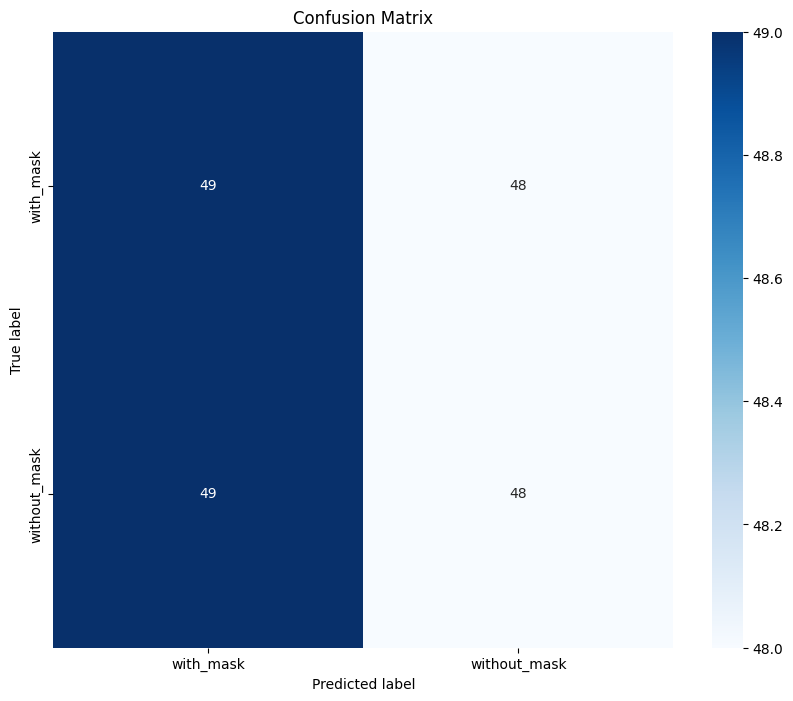

In [135]:
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show

In [136]:
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

   with_mask       0.50      0.51      0.50        97
without_mask       0.50      0.49      0.50        97

    accuracy                           0.50       194
   macro avg       0.50      0.50      0.50       194
weighted avg       0.50      0.50      0.50       194



In [137]:
def make_prediction(image_path):
    img = load_img(img_path, target_size=(150, 150))  # Resizing the image
    img_array = img_to_array(img)  # Converting to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.  # Rescale the image similarly as we did for the training data

    prediction = model.predict(img_array)
    print("Prediction:", prediction)

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')

    # Prediction
    plt.subplot(1, 2, 2)
    if prediction[0][0] > 0.5:
        plt.title('Predicted: Withoutmask')
    else:
        plt.title('Predicted: withmask')
    plt.imshow(img)  # Show the same image as prediction
    plt.axis('off')

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Prediction: [[0.2470341]]


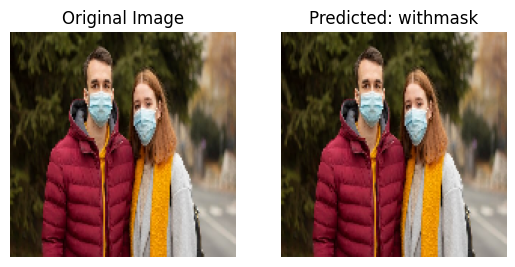

In [138]:
# Load and preprocess the image
img_path = '/kaggle/input/samples/samples/nd2.jpg'

make_prediction(img_path)

In [139]:
# Reset the test_generator before making predictions
test_generator.reset()

# Predict the whole test set
predictions = model.predict(test_generator, verbose=1)

# The predictions will be in the format of probabilities. You'll need to convert these to binary labels (0 or 1) based on a 0.5 threshold.
predicted_classes = (predictions > 0.5).astype(int).reshape(-1)
true_classes = test_generator.classes
misclassified_indices = np.where(predicted_classes != true_classes)[0]
misclassified_count = len(misclassified_indices)
print(f"Total misclassifications in the test set: {misclassified_count} out of {len(true_classes)}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Total misclassifications in the test set: 101 out of 194


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Total misclassifications: 97


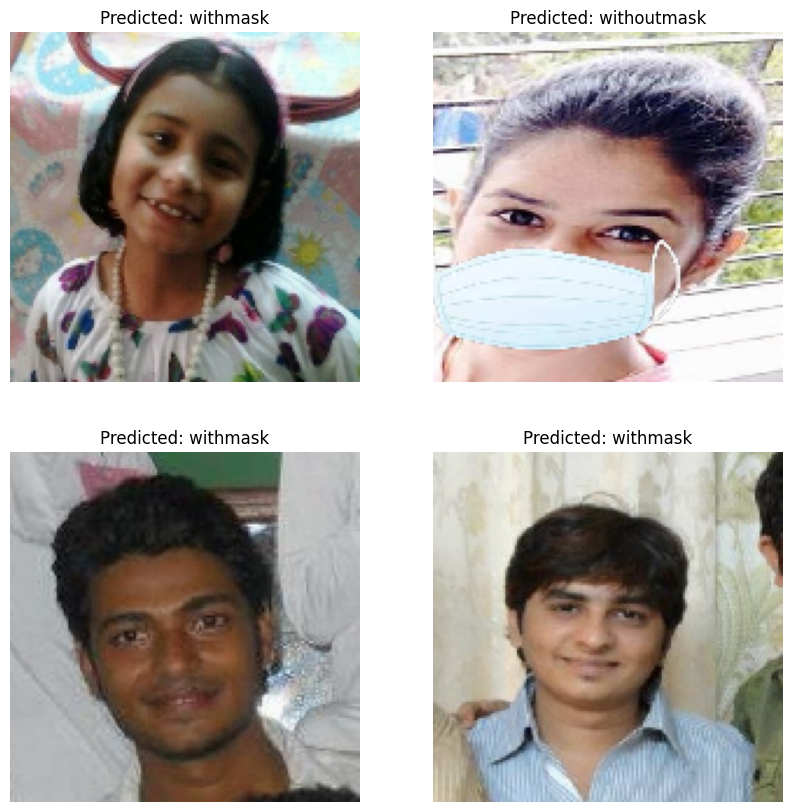

In [140]:
# Generate predictions for all test images
predictions = model.predict(test_generator)
# Convert predictions to binary (0 or 1) based on a 0.5 threshold
predicted_classes = predictions > 0.5

# Retrieve the true labels from the generator
true_classes = test_generator.classes

# Filenames can also be useful for debugging
filenames = test_generator.filenames
# Identifying indices of misclassified images
misclassified_indices = np.where(predicted_classes.flatten() != true_classes)[0]

print(f"Total misclassifications: {len(misclassified_indices)}")


# Select a random subset of misclassified images
num_samples_to_display = 4
random_indices = random.sample(list(misclassified_indices), num_samples_to_display)

# Plot
plt.figure(figsize=(10, 10))
for i, index in enumerate(random_indices, 1):
    # Load image
    img_path = test_data_dir + '/' + filenames[index]
    img = load_img(img_path, target_size=(150, 150))

    # Predicted class
    predicted_class = "withoutmask" if predicted_classes[index] else "withmask"

    # Display
    plt.subplot(2, 2, i)
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
plt.show()

In [141]:
model.save("ResNet50_model.keras")